Execute this cell below only when hosting code remotely.
This cell lets you import all code from https://github.com/maviddoerdijk/bsc-thesis/blob/main/src/.

Warning: when hosting remotely, none of the helper function code can be changed. Unless when you use specific branches.


In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

branch = "helper-function-additions"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 156 (delta 79), reused 71 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (156/156), 4.46 MiB | 7.90 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/bsc-thesis/src
backtesting/  data/       main.py  preprocessing/
config/       main.ipynb  models/  utils/


Now, let's start the notebook.

In [2]:
# Install missing Python packages in Google Colab
!pip install ta
!pip install prophet
!pip install pykalman
!pip install PyWavelets

In [23]:
# Import all packages
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import ta # technical indicators
import statsmodels.api as sm
import pywt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pykalman import KalmanFilter


# Custom helper functions
from data.data_collection import gather_data
from data.scraper import fetch_live_etf_tickers, load_cached_etf_tickers
from preprocessing.cointegration import find_cointegrated_pairs
from utils.visualization import plot_heatmap
from preprocessing.technical_indicators import add_technical_indicators
from preprocessing.ols import add_OLS
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.wavelet_denoising import wav_den
from models.statistical_models import default_normalize, execute_kalman_workflow

# Gather data

In [4]:
scrape_live = False
if scrape_live:
  instrumentIdsNASDAQandNYSE = fetch_live_etf_tickers()
else:
  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()

In [5]:
startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
data = gather_data(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)
data_close = data['close']
data_open = data['open']
data_high = data['high']
data_low = data['low']
data_vol = data['vol']

[*********************100%***********************]  777 of 777 completed
ERROR:yfinance:
533 Failed downloads:
ERROR:yfinance:['GSIB', 'IBTQ', 'IBTM', 'BRTR', 'QQQM', 'TTEQ', 'BSCW', 'FBOT', 'GBUG', 'MEMS', 'MAXI', 'GGLL', 'VOLT', 'TXUG', 'WNDY', 'SPCX', 'JPEF', 'YSPY', 'NERD', 'MNTL', 'NZUS', 'WRND', 'BDGS', 'BSMY', 'VRTL', 'LITP', 'PSWD', 'FMUN', 'TSPY', 'MYCI', 'QQQS', 'SMRI', 'ETHA', 'BSJR', 'MSTX', 'QHDG', 'NSI', 'COPP', 'FEAT', 'QQQH', 'TSL', 'AGIX', 'INDH', 'PATN', 'HLAL', 'SDTY', 'HRTS', 'MYMG', 'NVDS', 'RAYS', 'DFGP', 'QQQP', 'USSH', 'MYCF', 'HECO', 'ILIT', 'AAPB', 'LGCF', 'CANC', 'BRKU', 'ELIL', 'HYDR', 'FDNI', 'SEIS', 'BTFX', 'UTEN', 'BEEZ', 'TBIL', 'OOQB', 'WISE', 'DMAT', 'ICOP', 'UTWO', 'BRRR', 'IBTI', 'PCMM', 'AMZU', 'QCML', 'HOOG', 'OOSB', 'MQQQ', 'FINE', 'ABCS', 'BSCT', 'GPIQ', 'UFIV', 'CLOD', 'MULL', 'CCSB', 'LDEM', 'SOFX', 'RAA', 'MEDX', 'LEXI', 'GLCR', 'VGUS', 'EVYM', 'BSJU', 'TAXE', 'MKAM', 'GNOM', 'ORCX', 'ADBG', 'QYLG', 'ELIS', 'SARK', 'ELFY', 'AVGX', 'BUFC', 'SMC

# Prepocessing
## Filtering ETFs: step 1. remove NaNs

In [6]:
def step_1_filter_remove_nans(data_close, data_open, data_high, data_low, data_vol, data):
  d = data_close.isnull().any()
  valid_tickers = d[d == False].index

  # keep all the tickers where none of the entries are null
  data_close_filtered_1 = data_close[valid_tickers]
  data_open_filtered_1 = data_open[valid_tickers]
  data_high_filtered_1 = data_high[valid_tickers]
  data_low_filtered_1 = data_low[valid_tickers]
  data_vol_filtered_1 = data_vol[valid_tickers]
  data_original_format_filtered_1 = data['yfinance_formatted'][valid_tickers]
  return data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1

data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data_close, data_open, data_high, data_low, data_vol, data)
data_close_filtered_1

,SOXX,PTH,IGSB,QQXT,PUI,SCZ,PIO,IBB,AIA,PRN,...,QQEW,ICLN,BJK,TLT,SHY,PKW,PNQI,BND,RTH,GOVI
Date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,13.440000,8.273333,49.615002,16.309999,17.450001,33.340000,16.110001,26.913334,33.630001,24.559999,...,16.809999,37.150002,24.020000,95.779999,83.540001,20.059999,3.724000,74.949997,29.650000,27.080000
2008-10-02,12.626667,8.100000,49.959999,15.510000,16.790001,32.070000,15.160000,25.940001,31.799999,22.850000,...,16.129999,33.910000,23.100000,96.550003,83.720001,19.340000,3.566000,76.410004,28.600000,27.400000
2008-10-03,12.483333,7.976667,49.630001,15.210000,16.559999,31.160000,14.830000,25.633333,31.719999,22.510000,...,15.790000,33.410000,22.260000,97.400002,83.949997,19.129999,3.508000,75.989998,28.330000,27.459999
2008-10-06,12.060000,7.560000,48.419998,14.360000,15.670000,29.160000,13.780000,24.330000,29.270000,21.950001,...,14.810000,29.809999,19.750000,99.169998,84.120003,18.400000,3.186000,75.379997,27.366667,27.830000
2008-10-07,11.273333,7.320000,48.669998,13.910000,15.350000,28.110001,12.460000,23.373333,28.559999,20.889999,...,14.250000,26.629999,20.900000,98.870003,84.139999,17.510000,3.330000,75.599998,26.116667,27.760000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-25,61.976665,32.893333,51.759998,52.810001,28.299999,63.139999,25.799999,120.230003,62.709999,64.570000,...,63.180000,8.620000,40.470001,116.680000,83.040001,61.209999,26.788000,78.440002,110.660004,30.889999
2018-09-26,61.066666,32.533333,51.810001,53.360001,28.080000,63.150002,25.910000,120.610001,62.820000,64.160004,...,63.299999,8.620000,40.380001,117.500000,83.050003,61.130001,26.898001,78.639999,111.150002,31.070000
2018-09-27,61.296665,32.636665,51.820000,53.240002,28.350000,62.700001,25.740000,121.870003,63.070000,64.029999,...,63.599998,8.610000,39.930000,117.580002,83.050003,61.110001,27.122000,78.699997,111.400002,31.080000


## Filtering ETFs: step 2. liquidity

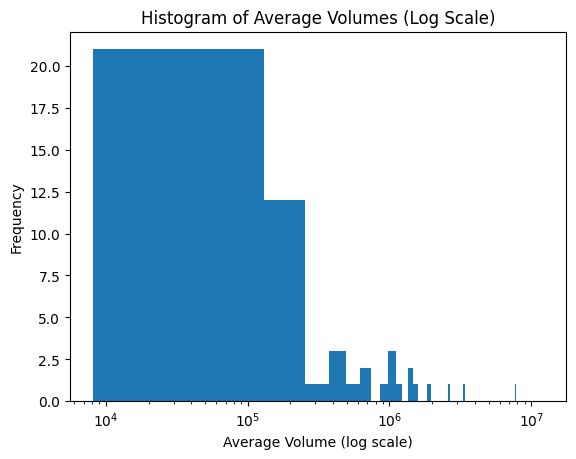

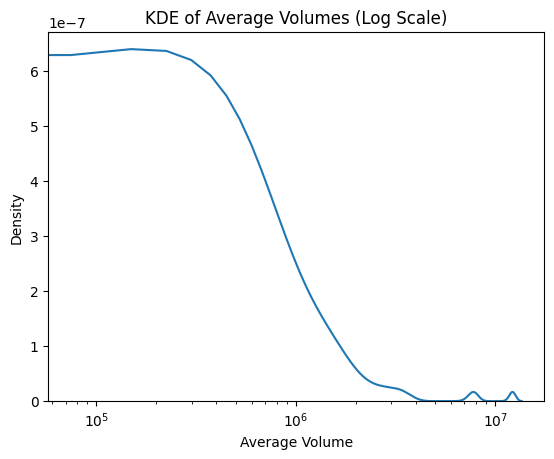

In [7]:
# data['yfinance_formatted'][['QQQ', 'IJJ']].xs('Volume', level='Price', axis=1)
min_vols = []
avg_vols = []
max_vols = []

for colnum in range(len(data_vol_filtered_1.columns)):
  # print(np.average(data_vol_filtered_1.iloc[:, colnum]))
  min_vols.append(np.min(data_vol_filtered_1.iloc[:, colnum]))
  avg_vols.append(np.average(data_vol_filtered_1.iloc[:, colnum]))
  max_vols.append(np.max(data_vol_filtered_1.iloc[:, colnum]))

plt.hist(avg_vols, bins=100)
plt.xscale('log')
plt.title("Histogram of Average Volumes (Log Scale)")
plt.xlabel("Average Volume (log scale)")
plt.ylabel("Frequency")
plt.show()

sns.kdeplot(avg_vols, bw_adjust=0.5)
plt.xscale('log')
plt.title("KDE of Average Volumes (Log Scale)")
plt.xlabel("Average Volume")
plt.show()

In [8]:
def step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1, liquidity_threshold = 10**5):
    avg_vols = data_vol_filtered_1.mean(axis=0)

    # find liquid tickers
    liquid_tickers = avg_vols[avg_vols > liquidity_threshold].index

    # similar to step 1, filter again using the tickers
    data_close_filtered_2 = data_close_filtered_1[liquid_tickers]
    data_open_filtered_2 = data_open_filtered_1[liquid_tickers]
    data_high_filtered_2 = data_high_filtered_1[liquid_tickers]
    data_low_filtered_2 = data_low_filtered_1[liquid_tickers]
    data_vol_filtered_2 = data_vol_filtered_1[liquid_tickers]
    data_original_format_filtered_2 = data_original_format_filtered_1[liquid_tickers]

    return data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2


data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)
data_close_filtered_2

,SOXX,IGSB,SCZ,IBB,DVY,PPH,TUR,BBH,IUSG,SMH,...,EMB,IUSV,IJT,IGIB,TLT,SHY,PKW,PNQI,BND,RTH
Date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,13.440000,49.615002,33.340000,26.913334,55.549999,33.500000,43.439999,60.250000,19.410000,12.125000,...,92.000000,28.056667,30.100000,46.009998,95.779999,83.540001,20.059999,3.724000,74.949997,29.650000
2008-10-02,12.626667,49.959999,32.070000,25.940001,53.669998,33.060001,40.000000,59.873333,18.480000,11.550000,...,91.360001,26.933332,28.520000,46.025002,96.550003,83.720001,19.340000,3.566000,76.410004,28.600000
2008-10-03,12.483333,49.630001,31.160000,25.633333,52.840000,32.849998,38.959999,60.266666,18.219999,11.450000,...,91.180000,26.389999,27.775000,45.700001,97.400002,83.949997,19.129999,3.508000,75.989998,28.330000
2008-10-06,12.060000,48.419998,29.160000,24.330000,51.000000,31.655001,35.889999,56.266666,17.490000,11.220000,...,90.029999,25.523333,26.965000,45.724998,99.169998,84.120003,18.400000,3.186000,75.379997,27.366667
2008-10-07,11.273333,48.669998,28.110001,23.373333,47.500000,30.424999,33.680000,54.033333,16.565001,10.475000,...,88.209999,23.860001,25.395000,45.735001,98.870003,84.139999,17.510000,3.330000,75.599998,26.116667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-25,61.976665,51.759998,63.139999,120.230003,100.660004,64.059998,23.420000,133.539993,62.009998,53.075001,...,107.209999,57.080002,101.599998,52.889999,116.680000,83.040001,61.209999,26.788000,78.440002,110.660004
2018-09-26,61.066666,51.810001,63.150002,120.610001,99.279999,63.939999,23.510000,134.529999,61.750000,52.605000,...,107.699997,56.419998,100.459999,53.049999,117.500000,83.050003,61.130001,26.898001,78.639999,111.150002
2018-09-27,61.296665,51.820000,62.700001,121.870003,99.320000,64.260002,24.030001,135.860001,62.049999,52.935001,...,108.080002,56.389999,100.599998,53.090000,117.580002,83.050003,61.110001,27.122000,78.699997,111.400002


# Find Co-Integrated Pairs

First, let's try to estimate the time we need.

In [9]:
import time
n_test_pairs = 10
start_time = time.time()
first_n_test_cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()[:n_test_pairs]
scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2[first_n_test_cols])
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")
seconds_per_pair = (end_time - start_time) / n_test_pairs
print(f"Seconds per pair: {seconds_per_pair:.2f}")

Completed 45 pairs
Execution time: 8.07 seconds
Seconds per pair: 0.81


In [10]:
from enum import unique


n_cols = len(data_original_format_filtered_2.columns.get_level_values('Ticker').unique())
max_cols = 30
if n_cols > max_cols and max_cols > 0:
    cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()[:max_cols]
    n_cols = max_cols
else:
    cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()
first_n_cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()[:n_cols]
# combinatorially find number of unique pairs of columns
unique_pairs = n_cols * (n_cols - 1) / 2
expected_time = unique_pairs * seconds_per_pair
print(f"Expected time to run all pairs: {expected_time / 60:.2f} minutes")

Expected time to run all pairs: 5.85 minutes


In [11]:
# First, we'll try it for a smaller (random) subset of the data
start_time = time.time()
scores, pvalues, pairs = find_cointegrated_pairs(data['yfinance_formatted'][first_n_cols])
# TODO: remove all perfectly cointegrated  variables where the error code shown below is given:
# /content/bsc-thesis/src/preprocessing/cointegration.py:62: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case. \ result = coint(S1, S2)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
pairs_data_filtered

Completed 435 pairs
Execution time: 65.52 seconds


[(('IGSB', 'PFF'), np.float64(3.432926060929387e-11)),
 (('IGSB', 'IFGL'), np.float64(6.792682448379846e-06)),
 (('EMB', 'SHY'), np.float64(2.3472860911249982e-05)),
 (('IGSB', 'SHY'), np.float64(0.00011659037067869815)),
 (('IGSB', 'PID'), np.float64(0.00013065834446531683)),
 (('IGSB', 'EMB'), np.float64(0.0005964786506590234)),
 (('IGSB', 'BBH'), np.float64(0.0006129783629473792)),
 (('IGIB', 'TLT'), np.float64(0.0007039730162819185)),
 (('EMB', 'TLT'), np.float64(0.0008242071808442096)),
 (('EMB', 'IUSV'), np.float64(0.0009412070917321167)),
 (('PFF', 'IGIB'), np.float64(0.0010572018262853824)),
 (('IGSB', 'TUR'), np.float64(0.0012000464207276634)),
 (('IGSB', 'SHV'), np.float64(0.0012639632665421795)),
 (('IGSB', 'PPH'), np.float64(0.0013347040611567185)),
 (('EMB', 'PKW'), np.float64(0.001376840723716427)),
 (('SHV', 'ONEQ'), np.float64(0.001416928906774011)),
 (('IGSB', 'IEI'), np.float64(0.0014210377492403314)),
 (('IGSB', 'DVY'), np.float64(0.0014398881633678113)),
 (('SHV', '

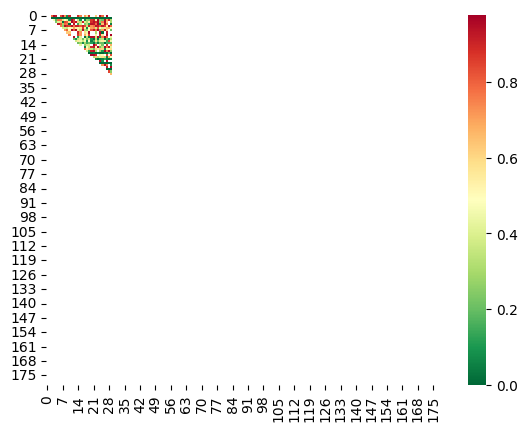

In [12]:
from utils.visualization import plot_heatmap
plot_heatmap(pvalues)

Most highly cointegrated pair: IGSB and PFF


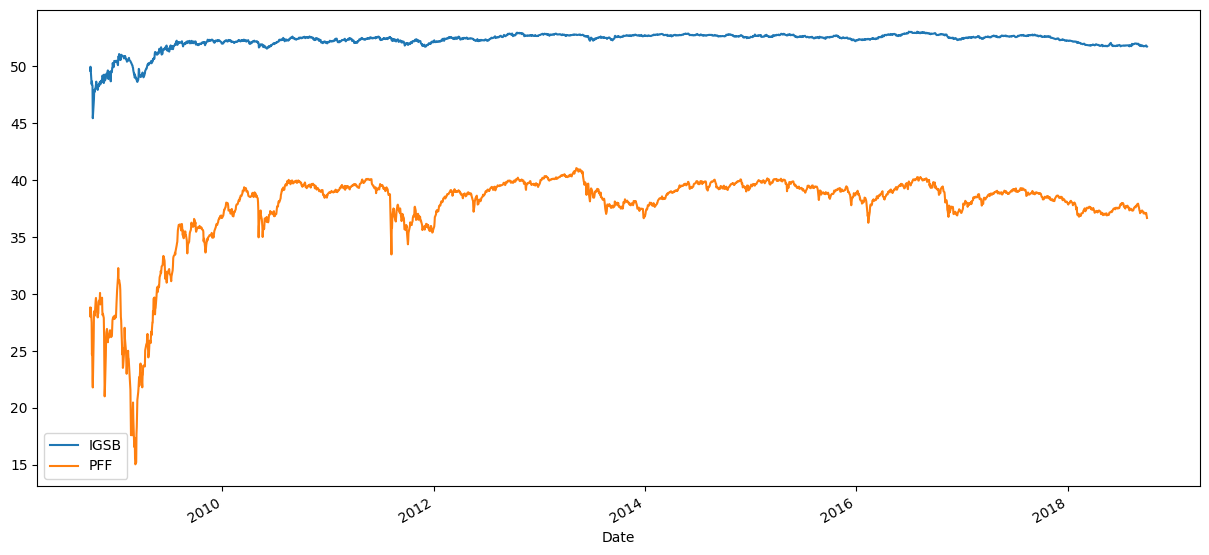

In [13]:
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
print(f"Most highly cointegrated pair: {ticker_a} and {ticker_b}")

pairs_timeseries = ({'S1_close':data_close_filtered_2[ticker_a],'S2_close':data_close_filtered_2[ticker_b]
                         ,'S1_open':data_open_filtered_2[ticker_a],'S2_open':data_open_filtered_2[ticker_b]
                         ,'S1_high':data_high_filtered_2[ticker_a],'S2_high':data_high_filtered_2[ticker_b]
                         ,'S1_low':data_low_filtered_2[ticker_a],'S2_low':data_low_filtered_2[ticker_b]
                         ,'S1_volume':data_vol_filtered_2[ticker_a],'S2_volume':data_vol_filtered_2[ticker_b]})
pairs_timeseries['S1_close'].plot(figsize=(15,7))
pairs_timeseries['S2_close'].plot(figsize=(15,7))
plt.legend([ticker_a, ticker_b])


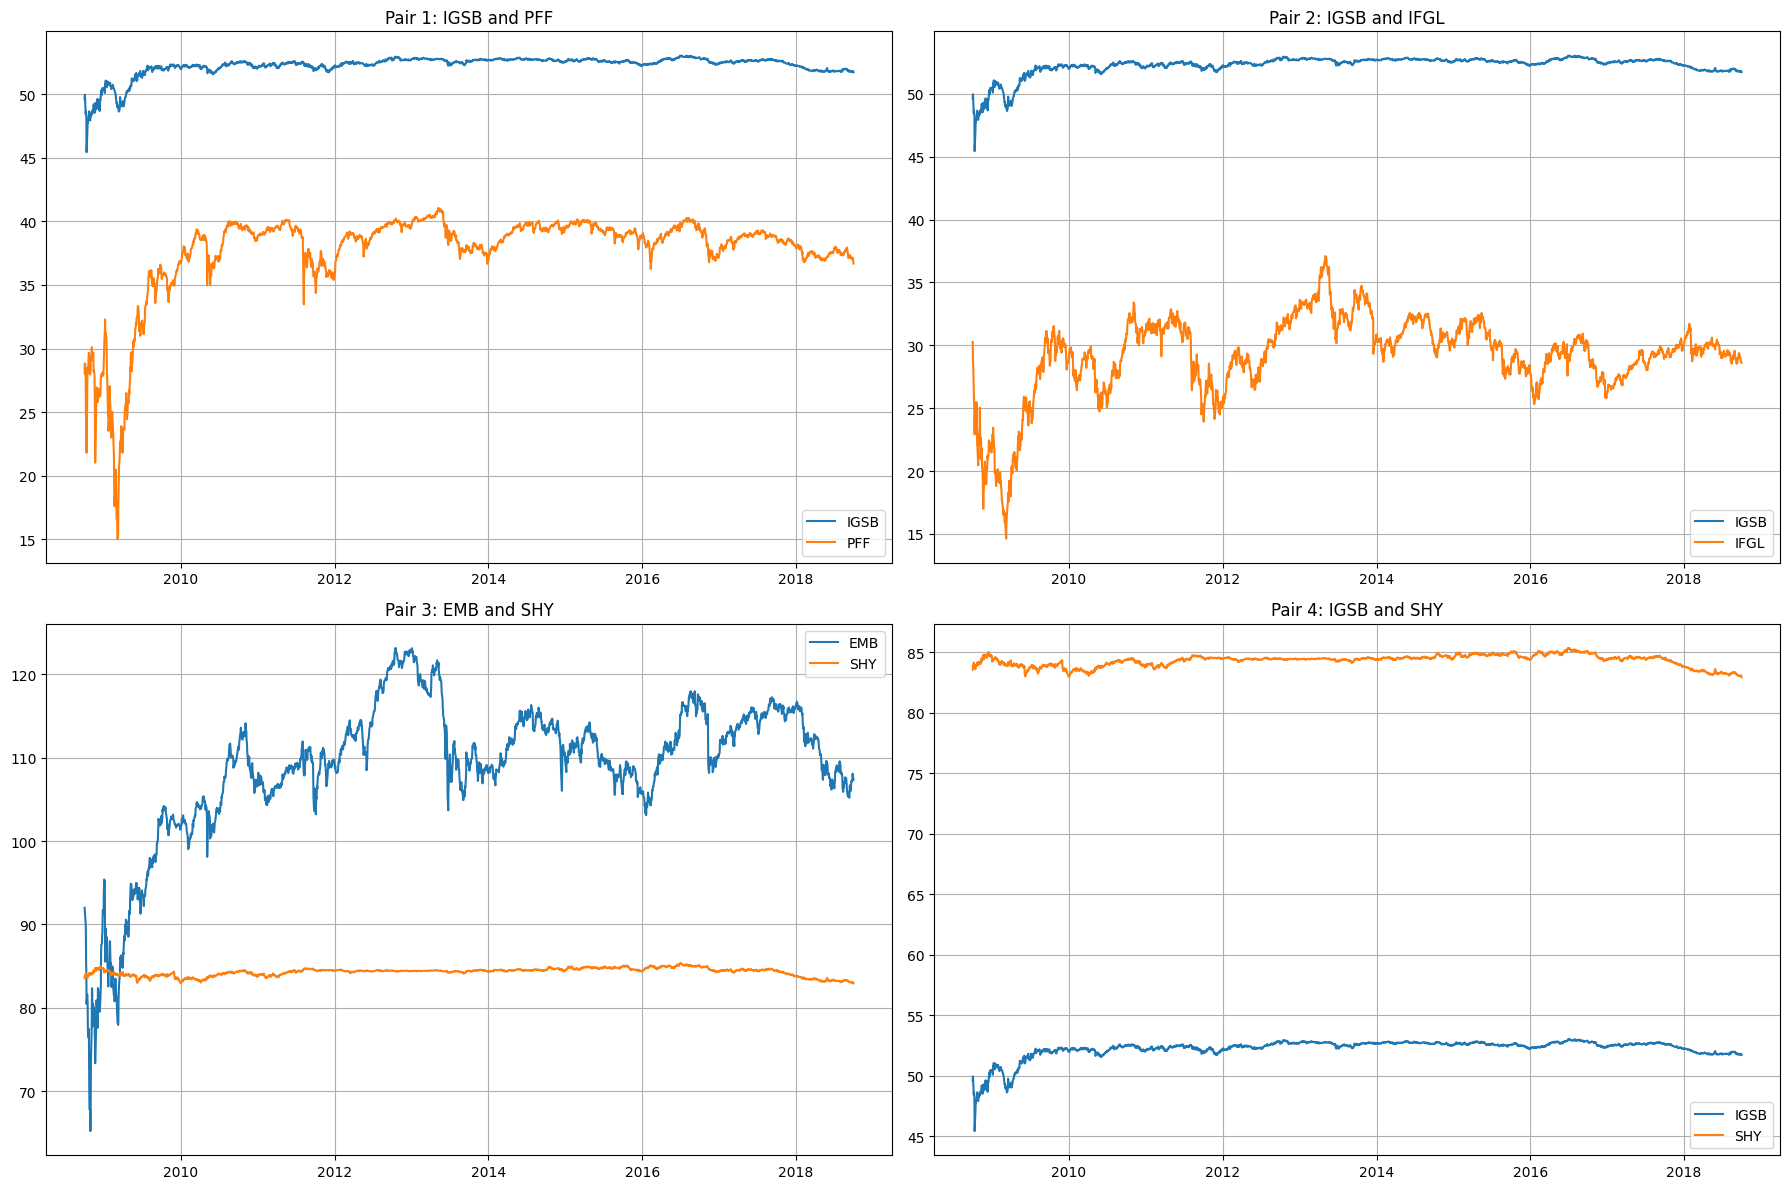

In [14]:
# Now Plot a grid of top 4 pairs
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.flatten()

for i in range(4):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]

    s1_close = data_close_filtered_2[ticker_a]
    s2_close = data_close_filtered_2[ticker_b]

    axs[i].plot(s1_close, label=ticker_a)
    axs[i].plot(s2_close, label=ticker_b)
    axs[i].set_title(f'Pair {i+1}: {ticker_a} and {ticker_b}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Training

Now, it's time for training.

Step 1: Adding Technical Indicators

In [15]:
pairs_timeseries_including_ta = add_technical_indicators(pairs_timeseries)
pairs_timeseries_final = add_OLS(pairs_timeseries_including_ta)

/content/bsc-thesis/src/preprocessing/ols.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = -est.params[0]
/content/bsc-thesis/src/preprocessing/ols.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_op = -est_op.params[0]
/content/bsc-thesis/src/preprocessing/ols.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_hi = -est_hi.params[0]
/content/bsc-thesis/src/preprocessing/ols.py:20: FutureWarning: Series.

Now, let's take a look at the (hopefully) mean-reverting spread.

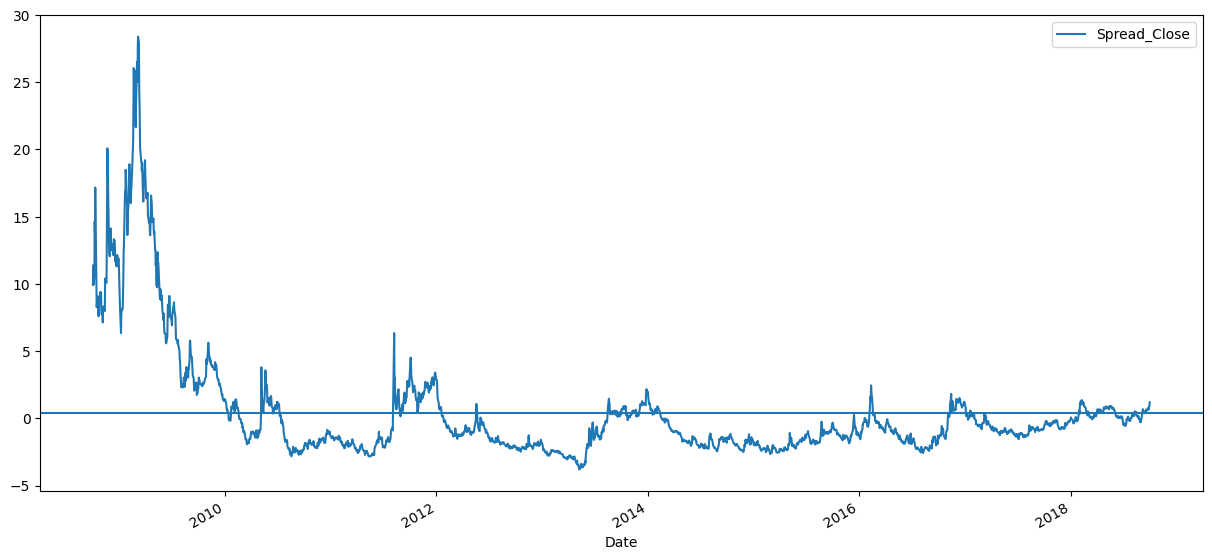

In [16]:
pairs_timeseries_final['Spread_Close'].plot(figsize=(15,7))
plt.axhline(pairs_timeseries_final['Spread_Close'].mean())
plt.legend(['Spread_Close'])

# Wavelet Denoising
Now, we apply simple wavelet denoising

In [17]:
#Use MinMaxScaler to normalize Weighted Price to range from 0 to 1
cols = ['Spread_Close', 'Spread_Open', 'Spread_High', 'Spread_Low', 'S1_volume',
                                          'S2_volume', 'S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi',
                                           'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx',
                                           'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']
lstm_pairs_timeseries = pd.DataFrame({'Spread_Close':pairs_timeseries_final['Spread_Close'][30:],
                               'Spread_Open':pairs_timeseries_final['Spread_Open'][30:],
                               'Spread_High':pairs_timeseries_final['Spread_High'][30:],
                               'Spread_Low':pairs_timeseries_final['Spread_Low'][30:],
                               'S1_volume':pairs_timeseries_final['S1_volume'][30:],
                               'S2_volume':pairs_timeseries_final['S2_volume'][30:],
                               'S1_rsi':pairs_timeseries_final['S1_rsi'][30:],
                               'S2_rsi':pairs_timeseries_final['S2_rsi'][30:],
                               'S1_mfi':pairs_timeseries_final['S1_mfi'][30:],
                               'S2_mfi':pairs_timeseries_final['S2_mfi'][30:],
                               'S1_adi':pairs_timeseries_final['S1_adi'][30:],
                               'S2_adi':pairs_timeseries_final['S2_adi'][30:],
                               'S1_vpt':pairs_timeseries_final['S1_vpt'][30:],
                               'S2_vpt':pairs_timeseries_final['S2_vpt'][30:],
                               'S1_atr':pairs_timeseries_final['S1_atr'][30:],
                               'S2_atr':pairs_timeseries_final['S2_atr'][30:],
                               'S1_bb_ma':pairs_timeseries_final['S1_bb_ma'][30:],
                               'S2_bb_ma':pairs_timeseries_final['S2_bb_ma'][30:],
                               'S1_adx':pairs_timeseries_final['S1_adx'][30:],
                               'S2_adx':pairs_timeseries_final['S2_adx'][30:],
                               'S1_ema':pairs_timeseries_final['S1_ema'][30:],
                               'S2_ema':pairs_timeseries_final['S2_ema'][30:],
                               'S1_macd':pairs_timeseries_final['S1_macd'][30:],
                               'S2_macd':pairs_timeseries_final['S2_macd'][30:],
                               'S1_dlr':pairs_timeseries_final['S1_dlr'][30:],
                               'S2_dlr':pairs_timeseries_final['S2_dlr'][30:]
                              }, columns = cols)

In [18]:
train_size = int(len(lstm_pairs_timeseries) * 0.9)
dev_size = int((len(lstm_pairs_timeseries) - train_size) * 0.5) - 30
test_size = len(lstm_pairs_timeseries) - train_size - dev_size
train, dev, test = lstm_pairs_timeseries[0:train_size], lstm_pairs_timeseries[train_size:train_size + dev_size], lstm_pairs_timeseries[train_size + dev_size:len(lstm_pairs_timeseries)]
print(len(train), len(dev), len(test))

2239 94 155


In [19]:
# first test whether wavelet denoising is working as expected
debug_train_den = pd.DataFrame(columns = cols)
col = cols[0]
train[col]

,Spread_Close
Date,
2008-11-12,9.885099
2008-11-13,10.407362
2008-11-14,10.132013
2008-11-17,10.086834
2008-11-18,12.888671
...,...
2017-09-28,-0.777177
2017-09-29,-0.800961
2017-10-02,-0.500147


In [20]:
train_den = pd.DataFrame(columns = cols)
for col in cols:
    train_den[col] = wav_den(train[col])

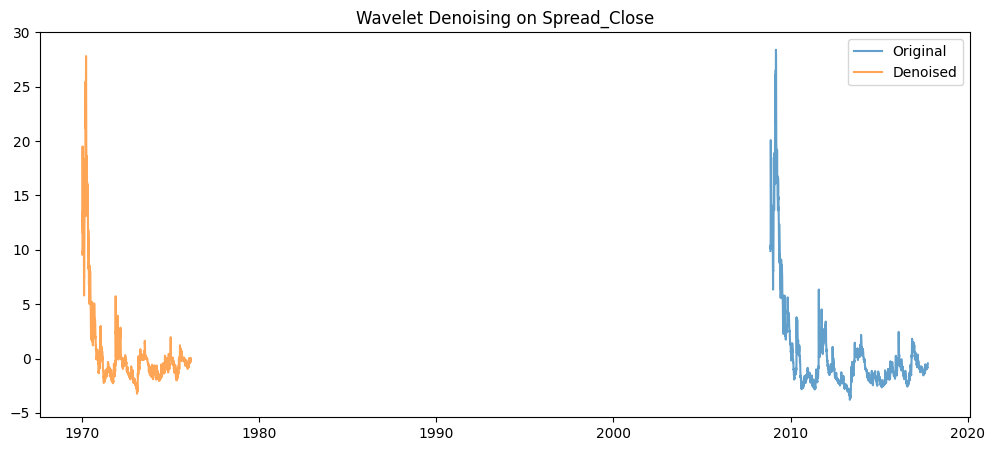

Original mean: 0.3108887173776676
Denoised mean: 0.5185411589896306
Original head: Date
2008-11-12     9.885099
2008-11-13    10.407362
2008-11-14    10.132013
2008-11-17    10.086834
2008-11-18    12.888671
2008-11-19    16.617230
2008-11-20    20.086725
2008-11-21    18.830981
2008-11-24    15.057653
2008-11-25    13.322155
Name: Spread_Close, dtype: float64
Denoised head: [ 9.82815394  9.55098889  9.5451165  12.34855284 16.03907932 19.50866491
 18.28750514 14.50783047 12.74496755 12.08806067]


In [21]:
# Possible columns:
# ['Spread_Close',
#  'Spread_Open',
#  'Spread_High',
#  'Spread_Low',
#  'S1_volume',
#  'S2_volume',
#  'S1_rsi',
#  'S2_rsi',
#  'S1_mfi',
#  'S2_mfi',
#  'S1_adi',
#  'S2_adi',
#  'S1_vpt',
#  'S2_vpt',
#  'S1_atr',
#  'S2_atr',
#  'S1_bb_ma',
#  'S2_bb_ma',
#  'S1_adx',
#  'S2_adx',
#  'S1_ema',
#  'S2_ema',
#  'S1_macd',
#  'S2_macd',
#  'S1_dlr',
#  'S2_dlr']
col = 'Spread_Close'
original = train[col]
denoised = wav_den(original)

plt.figure(figsize=(12, 5))
plt.plot(original, label='Original', alpha=0.7)
plt.plot(denoised, label='Denoised', alpha=0.7)
plt.legend()
plt.title(f'Wavelet Denoising on {col}')
plt.show()

print(f'Original mean: {original.mean()}')
print(f'Denoised mean: {denoised.mean()}')
print(f'Original head: {original[:10]}')
print(f'Denoised head: {denoised[:10]}')

2238
93
154
MSE: 0.9207612156459717


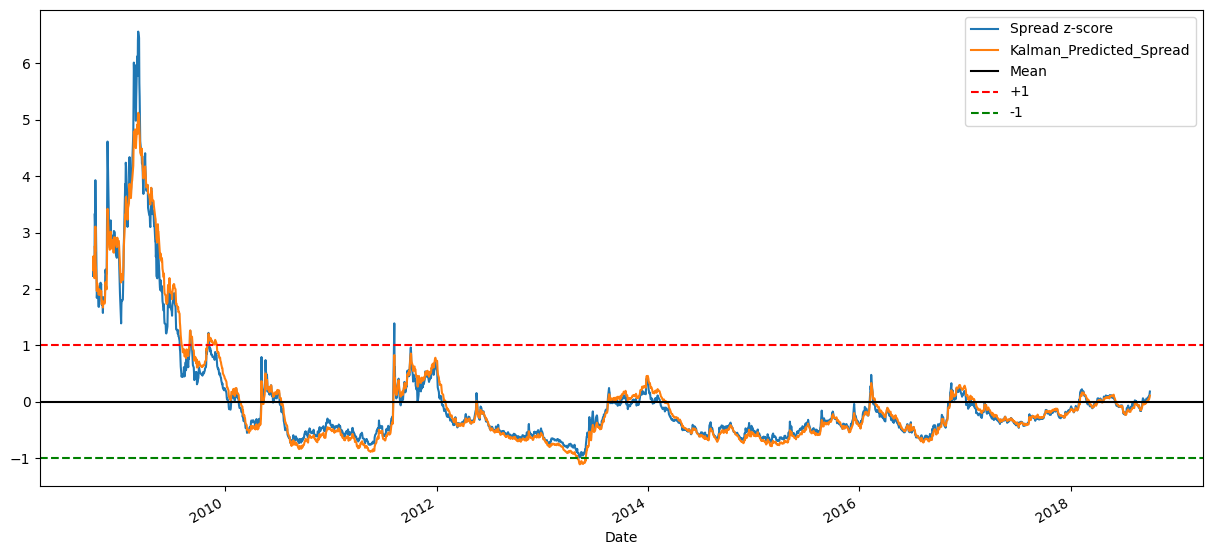

In [26]:
out_kalman = execute_kalman_workflow(
    pairs_timeseries_final,
    train_frac=0.8,              # ← change whatever you like
    dev_frac=0.1,
    look_back=1,
    verbose=True
)

print(f"MSE on test: {out_kalman['mse']:.5f}")

plt.figure(figsize=(15, 7))
default_normalize(pairs_timeseries_final['Spread_Close']).plot(label='Spread z-score')
out_kalman['kalman_result'].plot(label='Kalman predicted spread')
plt.axhline(0, color='black')
plt.axhline( 1, color='red',   ls='--')
plt.axhline(-1, color='green', ls='--')
plt.legend()
plt.title('Kalman Filter Prediction vs. Ground-truth Spread')
plt.show()